## Data collected so far

In [1]:
#Install proper packages

import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.11.4'

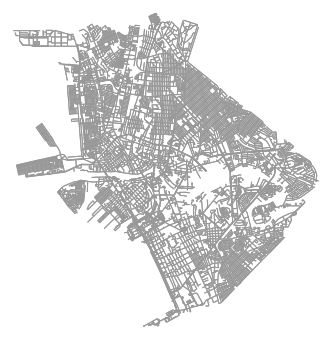

In [2]:
#Extract walking network for Manila

G = ox.graph_from_place('Manila, Philippines', network_type='walk',)
fig, ax = ox.plot_graph(G, node_size = 0)

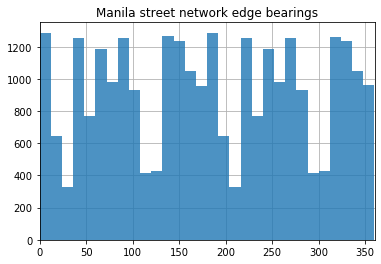

In [3]:
#Calculate edge bearings and visualize their frequency to better understand grid 

G = ox.add_edge_bearings(G)
bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
xlim = ax.set_xlim(0, 360)
ax.set_title('Manila street network edge bearings')
plt.show()

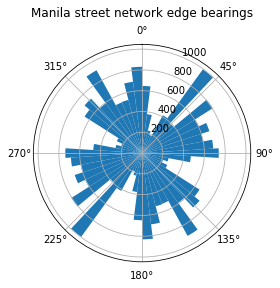

In [4]:
#Show edge bearings on a polar plot
#The grid is highly variable - a good sign for choice / connectivity

import numpy as np
n = 50
count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=0.0)
ax.set_title('Manila street network edge bearings', y=1.1)
plt.show()

In [5]:
#What sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

56493144.35435338

In [6]:
#Here I'm showing other basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 9282,
 'm': 28088,
 'k_avg': 6.0521439344968755,
 'intersection_count': 8134,
 'streets_per_node_avg': 3.0412626589097176,
 'streets_per_node_counts': {0: 0,
  1: 1148,
  2: 0,
  3: 5509,
  4: 2577,
  5: 42,
  6: 6},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.12368024132730016,
  2: 0.0,
  3: 0.5935143288084465,
  4: 0.27763413057530706,
  5: 0.004524886877828055,
  6: 0.0006464124111182935},
 'edge_length_total': 2004414.5880000037,
 'edge_length_avg': 71.36195485616646,
 'street_length_total': 1008792.8460000008,
 'street_length_avg': 71.6319566853654,
 'street_segments_count': 14083,
 'node_density_km': 164.30312219441413,
 'intersection_density_km': 143.9820723905801,
 'edge_density_km': 35480.66957341423,
 'street_density_km': 17856.907373969934,
 'circuity_avg': 1.0475318949278356,
 'self_loop_proportion': 0.002776986613500427,
 'clean_intersection_count': 4801,
 'clean_intersection_density_km': 84.98376316045919}

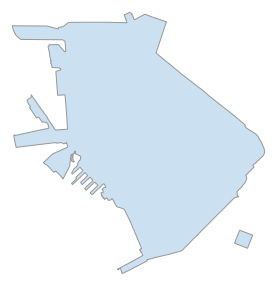

In [8]:
#Here I have a generic polygon for the city, which I can export (I think) as a shapefile

city = ox.gdf_from_place('Manila, Philippines')
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(5,5))

## Data I still need:
-Barangay polygons for Manila 

-Population density 

-Expected evacuation time from network

-Lots of other data regarding different anchor institutions 

## Random data that may or may not be helpful 

In [13]:
#GeoJSON of Rail Routes in Manila (there is one)
url = 'https://transit.land/api/v1/routes.geojson?operated_by=o-wdw4-philippinenationalrailways&per_page=false'

with open('routes.geojson', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [14]:
routes = gpd.read_file('routes.geojson')

In [16]:
routes.head() #Doesn't look too helpful...

,id,onestop_id,created_at,updated_at,tags,created_or_updated_in_changeset_id,name,vehicle_type,color,stops_served_by_route,operated_by_onestop_id,operated_by_name,wheelchair_accessible,bikes_allowed,title,geometry
0,r-wdw4-pnrmc,r-wdw4-pnrmc,2017-03-13T17:49:14,2017-05-16T21:01:44,{'route_url': 'http://www.pnr.gov.ph/metro_com...,5976,PNR MC,rail,E58E11,"[ { ""stop_onestop_id"": ""s-wdw50gcvjb-tutubanpn...",o-wdw4-philippinenationalrailways,Philippine National Railways,unknown,unknown,r-wdw4-pnrmc,"MULTILINESTRING ((120.97323 14.61161, 120.9737..."


In [17]:
#GeoJSON of rail stops in Manila (There are 34)
url = 'https://transit.land/api/v1/stops.geojson?served_by=o-wdw4-philippinenationalrailways&per_page=false'

with open('stops.geojson', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [18]:
stops = gpd.read_file('stops.geojson')

In [20]:
stops.head() #Again, doesn't seem super promising...

,id,onestop_id,created_at,updated_at,tags,created_or_updated_in_changeset_id,name,timezone,osm_way_id,parent_stop_onestop_id,wheelchair_boarding,geometry_reversegeo,geometry_centroid,operators_serving_stop,routes_serving_stop,title,geometry
0,s-wdw50gcvjb-tutubanpnr,s-wdw50gcvjb-tutubanpnr,2017-03-13T17:47:42,2020-03-10T17:07:21,"{'osm_way_id': '615871295', 'wheelchair_boardi...",5976,Tutuban PNR,Asia/Manila,615871295,None,None,None,"{'type': 'Point', 'coordinates': [120.97311973...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw50gcvjb-tutubanpnr,POINT (120.97312 14.61130)
1,s-wdw51jfq9k-blumentrittpnr,s-wdw51jfq9k-blumentrittpnr,2017-03-13T17:47:42,2020-03-04T15:09:49,"{'osm_way_id': '22918910', 'wheelchair_boardin...",5976,Blumentritt PNR,Asia/Manila,22918910,None,None,None,"{'type': 'Point', 'coordinates': [120.98459959...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw51jfq9k-blumentrittpnr,POINT (120.98460 14.62257)
2,s-wdw51kb6f6-dapitan~laonlaanpnr,s-wdw51kb6f6-dapitan~laonlaanpnr,2017-03-13T17:47:43,2020-03-04T03:55:35,"{'osm_way_id': '9162842', 'wheelchair_boarding...",5976,Dapitan/Laon Laan PNR,Asia/Manila,9162842,None,None,None,"{'type': 'Point', 'coordinates': [120.99288225...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw51kb6f6-dapitan~laonlaanpnr,POINT (120.99288 14.61642)
3,s-wdw51k556x-españapnr,s-wdw51k556x-españapnr,2017-03-13T17:47:44,2020-03-10T10:04:38,"{'osm_way_id': '9495736', 'wheelchair_boarding...",5089,España PNR,Asia/Manila,9495736,None,None,None,"{'type': 'Point', 'coordinates': [120.99666953...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw51k556x-españapnr,POINT (120.99667 14.61242)
4,s-wdw519uyzv-santamesapnr,s-wdw519uyzv-santamesapnr,2017-03-13T17:47:45,2020-03-10T15:46:50,"{'osm_way_id': '562605129', 'wheelchair_boardi...",5976,Santa Mesa PNR,Asia/Manila,562605129,None,None,None,"{'type': 'Point', 'coordinates': [121.01028442...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw519uyzv-santamesapnr,POINT (121.01028 14.60064)
